# Lab 2: Sequence Modeling and Parsing

In this lab we will implement two very popular algorithms in NLP (and other applications). Both algorithms employ dynamic programming to find the optimal solution in an efficient way. The Viterbi algorithm for sequence modeling recovers the most likely sequence underlying the input sequence while the CKY algorithm finds all the possible ways to parse the input with a predefined grammar.  
Let's dive into them...    

# Rules
* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.

* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header.

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells.
* Don't change the names of provided functions and variables or arguments of the functions.
* Leave the output of your code in the output cells.
* **Don't output unnecessary info** (e.g., printing variables for debugging purposes) or **add extra code cells** (e.g., for mounting your google drive). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.
* Don't forget to fill in the contribution information.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>

~~Delete this text and write instead of it your:~~
* ~~a list of group members names (NOT student IDs)~~
* ~~who contributed to which exercises (you don't need to be very detailed)~~

# General instructions

Before diving into the exercises, keep in mind that the variables defined previously can be reused in the subsequent cells. So there is no need to redefine the same variable in multiple sections, e.g., it is sufficient to read the file in a variable once and later reuse the value of the variable, instead of re-reading the file.   

If your code is too long and using several code cells instead of a single code cell. Rethink how to organize data in variables that you can easily access required info. Reading about [list comprehension](https://realpython.com/list-comprehension-python/#leverage-list-comprehensions) can be useful.

Your code will often be evaluated based on its behaviour. So, during the grading some code cells are executed. If code runtime is too long than expected, this will hinder grading.

<font color="red">**The cases similar to the above-mentioned ones, will be subject to penalty points.**</font>

<font color="red">**Pay attention to test units**</font> that are either provided as assert cases or as comments. Test units help you by giving you a hint about a correct answer. Note that **passing test units doesn't guarantee the full points** for an execise because test units are incomplete and the code might fail on other test units.

# Part 1: Sequence Models

In this lab, you will implement a **Hidden Markov Model (HMM)**. HMMs specify a **joint** probability over **observations** and **hidden states**.

This is what we will do:

1. **Estimate** a simple HMM model from training data (supervised learning)
2. Find the *best* sequence of hidden states for a given sequence of observations (we define "best" in 2 different ways!)

## Set up

In [ ]:
# Import modules
%matplotlib inline
import numpy as np
from collections import defaultdict, namedtuple

## Notation

$ \Sigma := \{ o_1, \dots, o_J \} $ is our set of **observations**

$\Lambda := \{s_1, \dots, s_K \}$ is our set of **state labels**

$\Sigma^*$ are **all possible sequences** of observations (including empty string $\epsilon$)

$\Lambda^*$ all possible sequences of hidden states (including empty string $\epsilon$)

> Extra info: we can say that $\Sigma^*$ is the [Kleene-closure](https://en.wikipedia.org/wiki/Kleene_star) of $\Sigma$, and $\Lambda^*$ the Kleene-closure of $\Lambda$.

## A simple example: The Baby HMM

We start with a simple example, so that we can easily verify that our code is correct.

Consider that we are modeling how a baby behaves. We observe the baby doing the following things: laughing (`laugh`), crying (`cry`), and sleeping (`sleep`). This is our set $\Sigma$ of **observations**.

We presume that, at any moment, the baby can be either `hungry`, `bored`, or `happy`. Since babies cannot talk, each of these states is hidden. This is our set $\Lambda$ of **hidden states**.

**Now the question is: if we have a series of observations, can we predict what hidden states the baby went through?**

To tackle this problem, we assume that the baby behaves like a **1st order discrete Markov chain**: the baby's current state only depends on its previous hidden state. The baby can be described as an HMM. (Yay!)

For example, assume we observed the baby doing the following:

```
sleep cry laugh cry
cry cry laugh sleep
```

We will use these sequences as our **test set**. We can try to find out the states of the baby for those observations.

Now, to train our model, we will need some examples of **observations** and **states**; this is our **training set**:

```
laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy
```

So we have **pairs** observation/state.

In [ ]:
# read in test data
test_data = """sleep cry laugh cry
cry cry laugh sleep"""

def test_reader(test_lines):
    for line in test_lines.splitlines():
        yield line.split()

test_set = list(test_reader(test_data))

# read in train data
train_data = """laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy"""

# for convenience, we define a Observation-State pair class
# fyi, more about namedtuple:
# https://docs.python.org/3/library/collections.html#collections.namedtuple
Pair = namedtuple("Pair", ["obs", "state"])
Pair.__repr__ = lambda x: x.obs + "/" + x.state

def train_reader(train_lines):
    for line in train_data.splitlines():
        # a pair is a string "observation/state" so we need to split on the "/"
        yield [Pair(*pair.split("/")) for pair in line.split()]

training_set = list(train_reader(train_data))

# print the results
print("test set (observations):")
for seq in test_set:
    print(seq)
print("\ntraining set (observation/state pairs):")
for seq in training_set:
    print(seq)

test set (observations):
['sleep', 'cry', 'laugh', 'cry']
['cry', 'cry', 'laugh', 'sleep']

training set (observation/state pairs):
[laugh/happy, cry/bored, cry/hungry, sleep/happy]
[cry/bored, laugh/happy, cry/happy, sleep/bored]
[cry/hungry, cry/bored, sleep/happy]


## Vocabularies

The `numpy` library is very practical when working with numeric vectors and matrices. Examples in this notebook heavily uses numpy arrays. It is recommended that you understand how simple arithmetic operation work on the arrays. You can also find very useful methods like `max` or `argmax` that will save several lines of code. You might find the following links useful: [NumPy Reference](https://numpy.org/doc/stable/reference/), [NumPy cheatsheets](https://blog.finxter.com/collection-10-best-numpy-cheat-sheets-every-python-coder-must-own/)

It's going to be very useful if we can map states and observations to integers, so that we can identify them by a number. If we don't do this, then our implementation will be longer and much slower (This is relevant when we work with larger data, e.g. for POS tagging).

Make sure you understand what is going on here: every time we look up an observation or state, the `defaultdict` will create a new key (index) if it has not seen that key (state or observation) before.

In [ ]:
# create mappings from state/obs to an ID
state2i = defaultdict(lambda: len(state2i))
obs2i = defaultdict(lambda: len(obs2i))

for seq in training_set:
    for example in seq:
        _ = state2i[example.state]
        _ = obs2i[example.obs]

print("\nOur vocabularies:")
print(state2i)
print(obs2i)


Our vocabularies:
defaultdict(<function <lambda> at 0x7f185c11eb90>, {'happy': 0, 'bored': 1, 'hungry': 2})
defaultdict(<function <lambda> at 0x7f185c11edd0>, {'laugh': 0, 'cry': 1, 'sleep': 2})


The HMM for the first training set sequence looks like this:

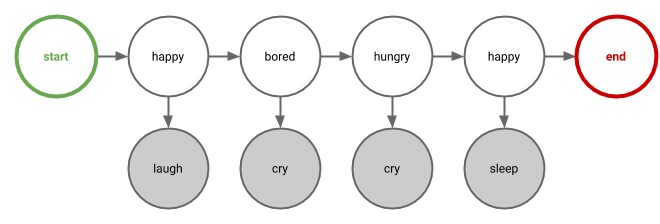

Now, we will **estimate** the following probability distributions:

- initial: $P( s_k \,|\, \texttt{start})$
- transition: $P( s_k \,|\, s_l )$
- final: $P(\texttt{stop} \,|\, s_k )$
- emission: $P( o_l \,|\, s_k)$

These distributions are all we need. Remember that:

- the probability of transitioning to a state $s_k$ only depends on one previous state $s_l$ (1st order Markov assumption).
- emitting an observation $o_l$ only depends on the state $s_k$.

## Finding the Maximum Likelihood Parameters

Now we would like to know what those distributions look like from our data. This is called **estimation**. Given our training data, we count how many times each event occurs and normalize the counts to form proper probability distributions.

Let's first do counts for the start probabilities:

In [ ]:
# we can get the number of states and observations from our dictionaries
num_states = len(state2i)
num_observations = len(obs2i)

# this creates a vector of length `num_states` filled with zeros
counts_start = np.zeros(num_states)

# now we count 1 every time a sequence starts with a certain state
# we look up the index for the state that we want to count using the `state2i` dictionary
for seq in training_set:
    counts_start[state2i[seq[0].state]] += 1.

print(counts_start)

[1. 1. 1.]


We see each state once at the beginning of a sequence in the training set, so that is why we have a count of 1 for each of them.

We now **normalize** those counts, so that we obtain a probability distribution:

In [ ]:
# since p_start is a numpy object, we can call sum on it; easy!
total = counts_start.sum()

# normalize: divide each count by the total
p_start = counts_start / total
print(f"start --> {p_start}")

start --> [0.33333333 0.33333333 0.33333333]


We now turn to the **transition probabilities** and **stop probabilities**. We count, and then we normalize:

In [ ]:
# we can transition from any state to any other state in principle,
# so we create a matrix filled with zeros so that we can count any pair of states
# in practice, some transitions might not occur in the training data
counts_trans = np.zeros((num_states, num_states))

# for the final/stop probabilities, we only need to store `num_states` values.
# so we use a vector
counts_stop = np.zeros(num_states)

# now we count transitions, one sequence at a time
for seq in training_set:
    for i in range(1, len(seq)):

        # convert the states to indexes
        prev_state = state2i[seq[i-1].state]
        current_state = state2i[seq[i].state]

        # count
        counts_trans[current_state, prev_state] += 1.
        # note that the order of states/indices in this matrix
        # follows conditional probability order p(q_i|q_{i-1})
        # not the transition matrix A_{i-1}_{i}

# count final states
for seq in training_set:
    state = state2i[seq[-1].state]
    counts_stop[state] += 1.

# print the counts
print("Transition counts:")
print(counts_trans)

print("Final counts:")
print(counts_stop)

Transition counts:
[[1. 2. 1.]
 [2. 0. 1.]
 [0. 1. 0.]]
Final counts:
[2. 1. 0.]


Now we can normalize again. We will need to collect the total counts per state.
Take some time to understand that the totals consist of the transition counts AND the final counts.

In [ ]:
# Useful trick: np.sum(m, 0) sums matrix m along the first dimension (with index 0).
# Note that after summing the dimension disappears
print(counts_trans.sum(0))

[3. 3. 2.]


In [ ]:
total_per_state = counts_trans.sum(0) + counts_stop
print(f"Total counts per state:\n{total_per_state}\n")

# now we normalize
# here '/' works one column at a time in the matrix
p_trans = counts_trans / total_per_state
print(f"Transition probabilities:\n{p_trans}\n")

# here '/' divides the values in each corresponding index in the 2 vectors
p_stop = counts_stop / total_per_state
print(f"Final probabilities:\n{p_stop}\n")

Total counts per state:
[5. 4. 2.]

Transition probabilities:
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]

Final probabilities:
[0.4  0.25 0.  ]



**So far so good!** Now let's take care of **emission probabilities**.

In [ ]:
# now we create a matrix to keep track of emission counts
# in principle any states can emit any observation
# so we need a matrix again:
# 1st dimension is for observations, 2nd is for states
# the dim. order follows conditional probabilities p(o|s)
counts_emiss = np.zeros((num_observations, num_states))

# count
for seq in training_set:
    for obs, state in seq:
        obs = obs2i[obs]
        state = state2i[state]
        counts_emiss[obs][state] += 1.

# normalize
p_emiss = counts_emiss / counts_emiss.sum(0)

print(f"emission counts:\n{counts_emiss}\n")
print(f"p_emiss:\n{p_emiss}\n")

emission counts:
[[2. 0. 0.]
 [1. 3. 2.]
 [2. 1. 0.]]

p_emiss:
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]



This is a good moment for a sanity check. First, take a look at the training set to see if these probabilities are correct, i.e. check if  for each state $s_k$: $$\sum_l P(s_l \,|\, s_k) = 1.0$$ Note that this includes transitions to "stop" state, so you have to take those into account.

## Decoding a sequence

Ok, so we have estimated a model. Great. Now what? Well, now we can **decode**!

Given an observation sequence $o_1, o_2, \dots, o_N$, we want to find the sequence of hidden states $s^* = s^*_1, s^*_2, \dots, s^*_N$ that **best** explains those observations.

But what does "best" mean?

1. If we are interested in the best **global** assignment of states to the sequence as a whole, we can use the **Viterbi** algorithm.
2. If we care more about minimizing the **local** error of getting each $s_i$ right, we can use **posterior decoding** (also called *max marginal decoding*).


### Decoding: The Viterbi Algorithm

Viterbi gives us the best global hidden state sequence, i.e.:

$$ \begin{array}{lll}
s^* &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N \,|\, o_1, o_2, \dots, o_N ) \\
    &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N, o_1, o_2, \dots, o_N )
\end{array}$$

To explain Viterbi we will make use of a **trellis**, a kind of graph that shows us the possible states for each time step.

For our earlier example, the trellis looks like this:

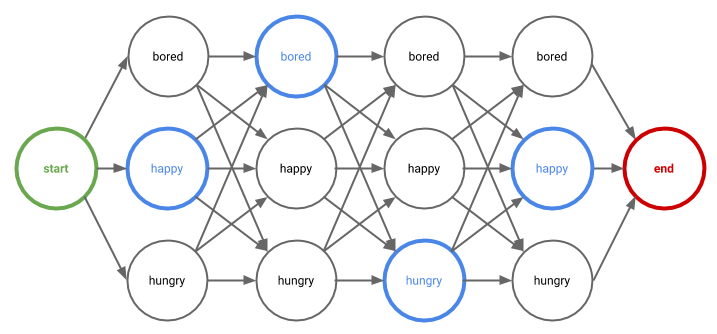

Note, that we can now label the edges of this trellis with the following probabilities:

- $P_{\text start}(s_k \,|\, \text{start})$ on the three edges from "start"
- $P_{\text stop}(\text{stop} \,|\, s_k)$ on the three edges leading to "stop"
- $P_{\text trans}(s_k \,|\, s_{l})$ on each remaining edge from state $s_l$ to $s_k$
- $P_{\text emiss}(o \,|\, s_k)$ from each state $s_k$, to an observation $o$ made from that state (not shown here)

Do you see that our trellis nicely shows the independence assumptions of the HMM?

### A Naive approach to get the best sequence

To see why the Viterbi algorithm is so useful, we can consider another way to calculate $s^*$:

- Iterate over all possible state sequences (all ways to go from `start` to `stop`)
    - Calculate the probability for that sequence
    - Store the highest probability seen so far and its sequence
- Return the sequence that had the maximum probability

The problem with this approach is that there are a lot of possible sequences!

## The Viterbi algorithm

*We use a slightly different notation here compared to the lecture.*

So how do we find the path with the highest score? The idea is that we can use our trellis to represent an **exponential number of paths**. Since we are only interested in the highest-scoring path, for every state at every time step, we only need to keep track of the **highest** probability that can lead us to that state. We can disregard any other paths that lead to that state, since they will for sure not be part of the highest-scoring path.

Viterbi uses **dynamic programming**. Here, that means that we will re-use probabilities that we have already computed, so we never have to compute the score for the same sub-problem multiple times.

Let's start at the beginning.

For the first time step, the **viterbi score** is the transition probability of reaching a state $s_k$ from "start", times the probability of emitting the first observation $o_1$ from that state:

$$\text{viterbi}(1, s_k) = P_{\text start}( s_k \,|\, \text{start}) \times P_{\text emiss}(o_1 \,|\, s_k)$$

So, the Viterbi trellis represents the path with maximum probability in position $i$ when we are in state $y_i$ having observed $o_1, o_2, \dots, o_i$, the observations up to and including that point.

Now that we have the viterbi scores for all states of the first time step in our trellis, we can use the following **recursive formula** to get the scores for all other states, one time step at a time:

$$\text{viterbi}(i, s_k) = \big( \max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l) \big) \times P_{\text emiss}(o_i \,|\, s_k)$$

Finally, for our final state "stop" we need to do something special, since there is no observation there:

$$\text{viterbi}(N+1, \text{stop}) = \max_{s_l \in \Lambda} P_{\text stop}(\text{stop} \,|\, s_l) \times \text{viterbi}(i-1, s_l)  $$

This is all we need to know what probability the highest scoring path has! Do you see how the dynamic programming helps us to solve this task efficiently?

## How did we get here?

Once we reach the "stop" state we know the maximum probability, but we forgot how we got there! If you don't see this immediately, remember that, whenever we computed the viterbi score for a state, we took the maximum over all previous states' viterbi scores, times the transition from those states. But we didn't keep track of which state was actually selected in that "max" operation. So now that we are in "stop", we don't know how we got there.

To solve this, we will use **backpointers**. Whenever we do a $\max$, we store what state was selected by that max (i.e. the $\arg\max$):

$$\text{backtrack}(i, s_k) = \arg\max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l)$$


## From probabilities to log-probabilities

Now you know enough to implement Viterbi! But before we start...  
Because probabilities tend to get rather small when multiplying, causing numerical instabilities, we will use **log probabilities**. This means that, instead of multiplying, we can now **sum** probabilities, because:

$$ \log(uv) = \log u + \log v$$

To get the probability of a  path trough our trellis from "start" to "stop", we can just **sum** the log-probabilities that we encounter. So, finding the best ("Viterbi") path means finding the path with the **highest score**.

In [ ]:
def convert_to_log(p_start=None, p_trans=None, p_stop=None, p_emiss=None):
    """
    Convert all probabilities to log-probabilities
    """
    return np.log(p_start), np.log(p_trans), np.log(p_stop), np.log(p_emiss)

print(f"Before:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

# do the conversion
lp_start, lp_trans, lp_stop, lp_emiss = \
    convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)

print(f"After:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Before:
[0.33333333 0.33333333 0.33333333]
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]
[0.4  0.25 0.  ]
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]
After:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.60943791 -0.69314718 -0.69314718]
 [-0.91629073        -inf -0.69314718]
 [       -inf -1.38629436        -inf]]
[-0.91629073 -1.38629436        -inf]
[[-0.91629073        -inf        -inf]
 [-1.60943791 -0.28768207  0.        ]
 [-0.91629073 -1.38629436        -inf]]


<ipython-input-10-77e2f4085654>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(p_start), np.log(p_trans), np.log(p_stop), np.log(p_emiss)


## Smoothing

Some probabilities were 0.0, and the log function is not defined for zero, resulting in a **warning** or `-inf` (depending on your numpy version).

To prevent this, we can add a small **smoothing** value to our **counts**, so that we never have a probability of zero.

To make things easier, we define a `normalize_all` function below that does all the normalization again,
but now adding a small value to all the counts.

In [ ]:
def normalize(x, smoothing=0.1, axis=0):
    smoothed = x + smoothing
    return smoothed / smoothed.sum(axis)

def normalize_all(counts_start, counts_trans, counts_stop, counts_emiss, smoothing=0.1):
    """Normalize all counts to probabilities, optionally with smoothing."""
    p_start = normalize(counts_start, smoothing=smoothing)
    p_emiss = normalize(counts_emiss, smoothing=smoothing)

    counts_trans_smoothed = counts_trans + smoothing
    counts_stop_smoothed = counts_stop + smoothing
    total_trans_stop = counts_trans_smoothed.sum(0) + counts_stop_smoothed
    p_trans = counts_trans_smoothed / total_trans_stop
    p_stop = counts_stop_smoothed / total_trans_stop

    return p_start, p_trans, p_stop, p_emiss


# normalize with smoothing
smoothing = 0.1
p_start, p_trans, p_stop, p_emiss = normalize_all(
    counts_start, counts_trans, counts_stop, counts_emiss, smoothing=smoothing)

In [ ]:
# convert to log-probabilities
print(f"Smoothed probabilities:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

lp_start, lp_trans, lp_stop, lp_emiss = convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
print(f"Smoothed log-probabilities:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Smoothed probabilities:
[0.33333333 0.33333333 0.33333333]
[[0.2037037  0.47727273 0.45833333]
 [0.38888889 0.02272727 0.45833333]
 [0.01851852 0.25       0.04166667]]
[0.38888889 0.25       0.04166667]
[[0.39622642 0.02325581 0.04347826]
 [0.20754717 0.72093023 0.91304348]
 [0.39622642 0.25581395 0.04347826]]
Smoothed log-probabilities:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.59108877 -0.7396672  -0.78015856]
 [-0.94446161 -3.78418963 -0.78015856]
 [-3.98898405 -1.38629436 -3.17805383]]
[-0.94446161 -1.38629436 -3.17805383]
[[-0.92576948 -3.76120012 -3.13549422]
 [-1.57239664 -0.32721291 -0.09097178]
 [-0.92576948 -1.36330484 -3.13549422]]


## Ex1 [40pt] Implement the Viterbi algorithm

You will now implement the Viterbi algorithm. Complete the function `viterbi(sequence, p_start, p_trans, p_emiss, p_stop)` below.

**Input:** sequence ($o_1, ..., o_N$), $P_\text{start}$, $P_\text{trans}$, $P_\text{emiss}$, $P_\text{stop}$

*Forward pass: compute the best path for every end state*

- set $\text{viterbi}(1, s_k)$ for each $s_k$
- for $i=2$ to $N$, and for each $s_k$, set $\text{viterbi}(i, s_k$) and $\text{backtrack}(i, s_k)$
- $\text{max_prob} = \max_{s_l} P_{\text{stop}}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$

*Backward pass: backtrack to get most likely path*
- $\hat{s}_N = \arg\max_{s_l} P_\text{stop}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$
- for $i = N-1$ to $1$: $\hat{s}_i = \text{backtrack}(i+1, \hat{s}_{i+1})$

**Output:** max_prob, Viterbi path $\hat{s}_1, \hat{s}_2, \dots, \hat{s}_N$

In [ ]:
def viterbi(sequence, lp_start=None, lp_trans=None, lp_stop=None, lp_emiss=None):
    """
    Compute the Viterbi sequence.
    Note: you have to use log-probabilities!

    The return value should be a tuple (max_prob, list_of_viterbi_states)
    Return:
      - best_score (float) the log-probability of the best path
      - best_path (int list) the best path as a list of state IDs
    """

    length = len(sequence)
    num_states = len(lp_start)

    # trellis to store Viterbi scores
    # we store -inf as our initial scores since log(0)=-inf
    trellis = np.full([length, num_states], -np.inf)

    # backpointers to backtrack (to remember what prev. state caused the maximum score)
    # we initialize with -1 values, to represent a non-existing index
    backpointers = -np.ones([length, num_states], dtype=int)

    # YOUR CODE HERE [we tested the code by computing the results by hand. It works]

#step 1: set viterbi(1,s_k) for each s_k: viterbi(1,s_k)=P[start](s_k|start)×P[emiss](o1|s_k)
    #since we're using log-probabilities, multiplication goes to adddition.
    #we populate the Viterbi scores of the start states.

    trellis[0] = lp_start + lp_emiss[obs2i[sequence[0]],:]

#step 2: for each s_k compute viterbi(i,s_k) for i=(2 to N) and store the backtrack(i,s_k)
    #viterbi(i,s_k)=(max[s_l∈Λ]Ptrans(s_k|s_l)×viterbi(i−1,s_l))×Pemiss(oi|s_k)

    for sequence_point in range(1, length):
      for state in range(num_states):
        #compute (P[trans](s_k|s_l) × viterbi(i−1,s_l)).
        log_viterbi = trellis[sequence_point - 1] + lp_trans[state, :]
        #compute the Viterbi score by taking the max of log_viterbi and adding the log of P[emiss](oi|s_k)
        trellis[sequence_point, state] = np.max(log_viterbi) + lp_emiss[obs2i[sequence[sequence_point]], state]
        #back track: output the indices of the maximum log_viterbi which identify the states
        backpointers[sequence_point, state] = np.argmax(log_viterbi)

#step 3: compute max_prob=max[s_l] (Pstop(stop|s_l)×viterbi(N,s_l))

    max_prob = trellis[-1] + lp_stop
    best_score = np.max(max_prob)

#step 4: backtrack to get most likely path
    best_path = []
    best_path.append(np.argmax(max_prob))
    for path in range(length - 1, 0, -1):
      best_path.append(backpointers[path, best_path[-1]])
    best_path.reverse()

    return best_score, best_path

## Trying out Viterbi

Once you have implemented the Viterbi algorithm, try it out on the following sequence.

Note: to get all points, make sure that the cell below runs.

In [ ]:
# TEST 1.1
# Test out your Viterbi-algorithm here

test_sequence = test_set[0]
best_score, best_path = viterbi(test_sequence, lp_start=lp_start, lp_trans=lp_trans, lp_stop=lp_stop, lp_emiss=lp_emiss)

print("observation=", test_sequence)
print(best_score)
print("best state sequence=", best_path)

i2state = {v : k for k, v in state2i.items()}
print([i2state[i] for i in best_path])

observation= ['sleep', 'cry', 'laugh', 'cry']
-7.619461837738772
best state sequence= [0, 1, 0, 1]
['happy', 'bored', 'happy', 'bored']


# Part 2: Constituency parsing with CKY

The grammatical structure of a sentence can be represented with a Context Free Grammar (CFG). When we additionally assign probabilities to the rules of the CFG we get a PCFG: a _Probabilistic_ CFG.

Given a sufficiently expressive PCFG (one that holds enough rules) we can parse new sentences using the Cocke–Kasami–Younger (CKY) algorithm. You can use this algorithm in three ways: to find the set of all the possible parses $p$ of a sentence $s$ under a PCFG $G$; to find the probability of the sentence by summing up the probabilities of these parses; or to find the parse $p^{*}$ of the highest probability.


### Tasks
1. In this notebook you will learn how to represent a PCFG in an object-oriented manner as a collection of python classes. These classes are already defined for you. Read them through thoroughly and make sure that you understand them well. You have to use them in task 2.

2. Implement the CKY algorithm to find the most probable parse $p^{*}$ for a sentence. Your implementation will follow the psuedo-code that is given in both the lecture slides, and Jurafsky and Martin.

## Set up

In [ ]:
import numpy as np
from collections import Counter, defaultdict
import math
# nltk will be used to draw constituency parses
import nltk
from nltk.tree import Tree

In [ ]:
# downloading grammar files
! wget -nv https://naturallogic.pro/_files_/download/mNLP/groucho-grammar-1.txt
! wget -nv https://naturallogic.pro/_files_/download/mNLP/groucho-grammar-2.txt
! wget -nv https://naturallogic.pro/_files_/download/mNLP/telescope-grammar.txt

2024-05-19 06:51:53 URL:https://naturallogic.pro/_files_/download/mNLP/groucho-grammar-1.txt [337/337] -> "groucho-grammar-1.txt.4" [1]
2024-05-19 06:51:54 URL:https://naturallogic.pro/_files_/download/mNLP/groucho-grammar-2.txt [337/337] -> "groucho-grammar-2.txt.4" [1]
2024-05-19 06:51:54 URL:https://naturallogic.pro/_files_/download/mNLP/telescope-grammar.txt [381/381] -> "telescope-grammar.txt.4" [1]


## PCFG

In this lab we will show you a way to represent a **PCFG** using python objects. We will introduce the following classes:

* Symbol
    * Terminal
    * Nonterminal
* Rule

At first glance, this might seem like a lot of work. But, hopefully, by the time you get to implementing CKY you will be convinced in the benefits of these constructions.

### Symbol

Recall that:
* **Terminal** symbols are the words of the sentence: _I, ate, salad, the_ etc.
* **Nonterminal** symbols are the syntactic categories of the various constituents: _S, NP, VP, Det_ etc.

In our representation, `Symbol` is going to be a container class. The classes `Terminal` and `Nonterminal` will *inherit* from the `Symbol` class and will hence both become a type of symbol. The classes themselves are effectively a container for the underlying python strings.

In [ ]:
class Symbol:
    """
    A symbol in a grammar.
    This class will be used as parent class for Terminal, Nonterminal.
    This way both will be a type of Symbol.
    """
    def __init__(self):
        pass


class Terminal(Symbol):
    """
    Terminal symbols are words in a vocabulary

    E.g. 'I', 'ate', 'salad', 'the'
    """

    def __init__(self, symbol: str):
        assert type(symbol) is str, f"A Terminal takes a python string, got {type(symbol)}"
        self._symbol = symbol

    def is_terminal(self):
        return True

    def is_nonterminal(self):
        return False

    def __str__(self):
        return f"'{self._symbol}'"

    def __repr__(self):
        return f"Terminal({repr(self._symbol)})"

    def __hash__(self):
        return hash(self._symbol)

    def __len__(self):
        """The length of the underlying python string"""
        return len(self._symbol)

    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol

    def __ne__(self, other):
        return not (self == other)

    def __lt__(self, other):
        return self._symbol < other._symbol

    @property
    def obj(self):
        """Returns the underlying python string"""
        return self._symbol


class Nonterminal(Symbol):
    """
    Nonterminal symbols are the grammatical classes in a grammar.

    E.g. S, NP, VP, N, Det, etc.
    """

    def __init__(self, symbol: str):
        assert type(symbol) is str, f"A Nonterminal takes a python string, got {type(symbol)}"
        self._symbol = symbol

    def is_terminal(self):
        return False

    def is_nonterminal(self):
        return True

    def __str__(self):
        return f"[{self._symbol}]"

    def __repr__(self):
        return f"Nonterminal({repr(self._symbol)})"

    def __hash__(self):
        return hash(self._symbol)

    def __len__(self):
        """The length of the underlying python string"""
        return len(self._symbol)

    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol

    def __ne__(self, other):
        return not (self == other)

    def __lt__(self, other):
        return self._symbol < other._symbol

    @property
    def obj(self):
        """Returns the underlying python string"""
        return self._symbol

Let's try out the classes by initializing some terminal and nonterminal symbols:

In [ ]:
dog = Terminal('dog')
the = Terminal('the')
walks = Terminal('walks')

S = Nonterminal('S')
NP = Nonterminal('NP')
NP_prime = Nonterminal('NP')
VP = Nonterminal('VP')
V = Nonterminal('V')
N = Nonterminal('N')
Det = Nonterminal('Det')

The methods `__eq__` and `__ne__` make it possible to compare our objects using standard Python syntax. But more importantly: compare in the way that we are interested in, namely whether the underlying representation is the same.

To see the difference, try commenting out the method `__eq__` in the class above, and notice the different result of the equality test `NP==NP_prime`.

In [ ]:
print(dog)
print(NP)
print()
print(NP==Det)
print(NP!=Det)
print(NP==NP)
print(NP==NP_prime)

'dog'
[NP]

False
True
True
True


Note the difference between calling `print(NP)` and simply calling `NP`. The first is taken care of by the method `__str__` and the second by the method `__repr__`.

In [ ]:
dog

Terminal('dog')

We can also easily check if our symbol is a terminal or not:

In [ ]:
dog.is_terminal()

True

In [ ]:
NP.is_terminal()

False

Finally the method `__hash__` makes our object *hashable*, and hence usable in a datastructure like a dictionary.

Try commenting out this method above in the class and then retry constructing the dictionary: notice the error.

In [ ]:
d = {NP: 1, S: 2}
d

{Nonterminal('NP'): 1, Nonterminal('S'): 2}

### Rules

In a PCFG a **rule** looks something like this

$$NP \to Det\;N$$

with a corresponding probability, for example $1.0$ if we lived in a world where all noun phrases had this grammatical structure.

In our representation, `Rule` will be an object made of a left-hand side (`lhs`) symbol, a sequence of right-hand side symbols (`rhs`) and a probability `prob`.

If we use the above defined symbols, we can call

    rule = Rule(NP, [Det, N], 1.0)
   
This will construct an instance called `rule` which represent the rule above

    [NP] -> [Det] [N] (1.0)
    

In [ ]:
class Rule:

    def __init__(self, lhs, rhs, prob):
        """
        Constructs a Rule.
        A Rule takes a LHS symbol and a list/tuple of RHS symbols.

        :param lhs: the LHS nonterminal
        :param rhs: a sequence of RHS symbols (terminal or nonterminal)
        :param prob: probability of the rule
        """

        assert isinstance(lhs, Symbol), 'LHS must be an instance of Symbol (actually even a non-terminal but later we will expan LHS)'
        assert len(rhs) > 0, 'If you want an empty RHS, use an epsilon Terminal EPS'
        assert all(isinstance(s, Symbol) for s in rhs), 'RHS must be a sequence of Symbol objects'
        if prob is not None:
            assert 0 <= prob <= 1, 'The probability must be between 0 and 1'
        self._lhs = lhs
        self._rhs = tuple(rhs)
        self._prob = prob


    def __eq__(self, other):
        return self._lhs == other._lhs and self._rhs == other._rhs and self._prob == other._prob

    def __ne__(self, other):
        return not (self == other)

    def __hash__(self):
        return hash((self._lhs, self._rhs, self._prob))

    def __repr__(self):
        rhs = ' '.join(str(sym) for sym in self._rhs)
        return f"{self._lhs} -> {rhs} ({self.prob})"

    def is_binary(self):
        """True if Rule is binary: A -> B C"""
        return len(self._rhs) == 2

    def is_unary(self):
        """True if Rule is unary: A -> w"""
        return len(self._rhs) == 1

    @property
    def lhs(self):
        """Returns the lhs of the rule"""
        return self._lhs

    @property
    def rhs(self):
        """Returns the rhs of the rule"""
        return self._rhs

    @property
    def prob(self):
        """Returns the probability of the rule"""
        return self._prob


Just as with `Terminal` and `Nonterminal` you can print an instance of `Rule`, you can access its attributes, and you can hash rules with containers such as dict and set.

In [ ]:
r1 = Rule(S, [NP, VP], 1.0)
r2 = Rule(NP, [Det, N], 1.0)
r3 = Rule(N, [dog], 1.0)
r4 = Rule(Det, [the], 1.0)
r5 = Rule(VP, [walks], 1.0)

print(r1)
print(r2)
print(r3)
print(r4)

[S] -> [NP] [VP] (1.0)
[NP] -> [Det] [N] (1.0)
[N] -> 'dog' (1.0)
[Det] -> 'the' (1.0)


In [ ]:
print(r1.prob)

1.0


In [ ]:
r1 in set([r1])

True

In [ ]:
d = {r1: 1, r2: 2}
d

{[S] -> [NP] [VP] (1.0): 1, [NP] -> [Det] [N] (1.0): 2}

### Grammar

A `PCFG` class is a container for `Rules`. The `Rules` are stored in the `PCFG` in such a way that they can be accesed easily in different ways.

In [ ]:
class PCFG(object):
    """
    Constructs a PCFG.
    A PCFG stores a list of rules that can be accessed in various ways.

    :param rules: an optional list of rules to initialize the grammar with
    """
    def __init__(self, rules=[]):
        self._rules = []
        self._rules_by_lhs = defaultdict(list)
        self._terminals = set()
        self._nonterminals = set()
        for rule in rules:
            self.add(rule)

    def add(self, rule):
        """Adds a rule to the grammar"""
        if not rule in self._rules:
            self._rules.append(rule)
            self._rules_by_lhs[rule.lhs].append(rule)
            self._nonterminals.add(rule.lhs)
            for s in rule.rhs:
                if s.is_terminal():
                    self._terminals.add(s)
                else:
                    self._nonterminals.add(s)

    def update(self, rules):
        """Add a list of rules to the grammar"""
        for rule in rules:
            self.add(rule)

    @property
    def nonterminals(self):
        """The list of nonterminal symbols in the grammar"""
        return self._nonterminals

    @property
    def terminals(self):
        """The list of terminal symbols in the grammar"""
        return self._terminals

    @property
    def rules(self):
        """The list of rules in the grammar"""
        return self._rules

    @property
    def binary_rules(self):
        """The list of binary rules in the grammar"""
        return [rule for rule in self._rules if rule.is_binary()]

    @property
    def unary_rules(self):
        """The list of unary rules in the grammar"""
        return [rule for rule in self._rules if rule.is_unary()]

    def __len__(self):
        return len(self._rules)

    def get(self, lhs):
        """The list of rules whose LHS is the given symbol lhs"""
        return self._rules_by_lhs.get(lhs, [])

    def __iter__(self):
        """Iterator over rules (in arbitrary order)"""
        return iter(self._rules)

    def iteritems(self):
        """Iterator over pairs of the kind (LHS, rules rewriting LHS)"""
        return self._rules_by_lhs.items()

    def __str__(self):
        """Prints the grammar line by line"""
        lines = []
        for lhs, rules in self.iteritems():
            for rule in rules:
                lines.append(str(rule))
        return '\n'.join(lines)

Initialize a grammar

In [ ]:
G = PCFG()

We can add rules individually with `add`, or as a list with `update`:

In [ ]:
G.add(r1)
G.update([r2,r3,r4,r5])

We can print the grammar

In [ ]:
print(G)

[S] -> [NP] [VP] (1.0)
[NP] -> [Det] [N] (1.0)
[N] -> 'dog' (1.0)
[Det] -> 'the' (1.0)
[VP] -> 'walks' (1.0)


We can get the set of rewrite rules for a certain LHS symbol.

In [ ]:
G.get(S)

[[S] -> [NP] [VP] (1.0)]

In [ ]:
G.get(NP)

[[NP] -> [Det] [N] (1.0)]

We can also iterate through rules in the grammar.

Note that the following is basically counting how many rules we have in the grammar.

In [ ]:
sum(1 for r in G)

5

which can also be done in a more efficient way

In [ ]:
len(G)

5

We can access the set of terminals and nonterminals of the grammar:

In [ ]:
print(G.nonterminals)

{Nonterminal('S'), Nonterminal('NP'), Nonterminal('Det'), Nonterminal('N'), Nonterminal('VP')}


In [ ]:
print(G.terminals)

{Terminal('the'), Terminal('walks'), Terminal('dog')}


In [ ]:
S in G.nonterminals

True

In [ ]:
dog in G.terminals

True

Finally we can easily access all the binary rules and all the unary rules in the grammar:

In [ ]:
G.unary_rules

[[N] -> 'dog' (1.0), [Det] -> 'the' (1.0), [VP] -> 'walks' (1.0)]

In [ ]:
G.binary_rules

[[S] -> [NP] [VP] (1.0), [NP] -> [Det] [N] (1.0)]

## Visualizing a tree

For the sake of legacy let's reiterate an age-old NLP schtick, the well-known example of structural ambiguity from the Groucho Marx movie, [Animal Crackers](https://youtu.be/FZUfhfHbjE4?t=1m33s) (1930):

> One morning I shot an elephant in my pajamas. How he got into my pajamas, I don't know.

Let's take a closer look at the ambiguity in the phrase: _I shot an elephant in my pajamas_. The ambiguity is caused by the fact that the sentence has two competing parses represented in:

    (S (NP I) (VP (VP (V shot) (NP (Det an) (N elephant))) (PP (P in) (NP (Det my) (N pajamas)))))

and

    (S (NP I) (VP (V shot) (NP (Det an) (NP (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))))


We can write these parses down as strings and then let NLTK turn them into trees using the NLTK `Tree` class. (See http://www.nltk.org/api/nltk.html#nltk.tree.Tree as reference for this class, if you want to know more.)

In [ ]:
parse1 = "(S (NP I) (VP (VP (V shot) (NP (Det an) (N elephant))) (PP (P in) (NP (Det my) (N pajamas)))))"
parse2 = "(S (NP I) (VP (V shot) (NP (Det an) (NP (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))))"

pajamas1 = Tree.fromstring(parse1)
pajamas2 = Tree.fromstring(parse2)

We can then *pretty-print* these trees:

In [ ]:
pajamas1.pretty_print()
pajamas2.pretty_print()

     S                                       
  ___|______________                          
 |                  VP                       
 |         _________|__________               
 |        VP                   PP            
 |    ____|___              ___|___           
 |   |        NP           |       NP        
 |   |     ___|_____       |    ___|_____     
 NP  V   Det        N      P  Det        N   
 |   |    |         |      |   |         |    
 I  shot  an     elephant  in  my     pajamas

     S                                       
  ___|__________                              
 |              VP                           
 |    __________|______                       
 |   |                 NP                    
 |   |     ____________|___                   
 |   |    |                NP                
 |   |    |      __________|___               
 |   |    |     |              PP            
 |   |    |     |       _______|___           
 |   |    |     |      

## Parsing with CKY

Let's stick with this sentence for the rest of this lab. We will use CKY to find the 'best' parse for this sentence.

In [ ]:
# Turn the sentence into a list
sentence = "I shot an elephant in my pajamas".split()
# The length of the sentence
num_words = len(sentence)

A PCFG for this sentence can be found in the file `groucho-grammar-1.txt`. We read this in with the function `read_grammar_rules`.

In [ ]:
def read_grammar_rules(istream):
    """Reads grammar rules formatted as 'LHS ||| RHS ||| PROB'."""
    for line in istream:
        line = line.strip()
        if not line: continue
        fields = line.split('|||')
        if len(fields) != 3:
            raise ValueError(f"Three fields were expected: {fields}")
        lhs = fields[0].strip()

        if lhs.startswith('[') and lhs.endswith(']'):
            lhs = Nonterminal(lhs[1:-1])
        else:
            raise ValueError(f"LHS must be a non-terminal: {fields}")
        rhs = fields[1].strip().split()
        new_rhs = []
        for r in rhs:
            if r.startswith('[') and r.endswith(']'):
                r = Nonterminal(r[1:-1])
            else:
                r = Terminal(r)
            new_rhs.append(r)

        prob = float(fields[2].strip())
        yield Rule(lhs, new_rhs, prob)

In [ ]:
# Read in the grammar
with open('groucho-grammar-1.txt') as F:
    grammar = PCFG(read_grammar_rules(F))
print("The grammar:\n", grammar)

The grammar:
 [S] -> [NP] [VP] (1.0)
[PP] -> [P] [NP] (1.0)
[NP] -> [Det] [N] (0.2)
[NP] -> [Det] [NP] (0.3)
[NP] -> [N] [PP] (0.3)
[NP] -> 'I' (0.2)
[VP] -> [V] [NP] (0.4)
[VP] -> [VP] [PP] (0.6)
[Det] -> 'an' (0.6)
[Det] -> 'my' (0.4)
[N] -> 'elephant' (0.5)
[N] -> 'pajamas' (0.5)
[V] -> 'shot' (1.0)
[P] -> 'in' (1.0)


We will also need the following two dictionaries: `nonterminal2index` mapping from nonterminals to integers (indices); and its inverse, an `index2nonterminal` dictionary.

In [ ]:
num_nonterminals = len(grammar.nonterminals)

# Make a nonterminal2index and a index2nonterminal dictionary
n2i = defaultdict(lambda: len(n2i))
i2n = dict()

# sort nonterminals to make the mapping deterministic
for nt in sorted(grammar.nonterminals):
    i2n[n2i[nt]] = nt

# Stop defaultdict behavior of n2i
n2i = dict(n2i)

n2i

{Nonterminal('Det'): 0,
 Nonterminal('N'): 1,
 Nonterminal('NP'): 2,
 Nonterminal('P'): 3,
 Nonterminal('PP'): 4,
 Nonterminal('S'): 5,
 Nonterminal('V'): 6,
 Nonterminal('VP'): 7}

### The charts

Now we are ready to introduce the chart datastructures. We need a chart to store the **scores** and a chart to store the **backpointers**.

Both of these will be 3-dimensional numpy arrays: one named `score` holding the probabilities of intermediate results; one named `back` to store the backpointers in. We will use the following indexing convention for these charts:

* Format of the chart holding the **scores** `score[A][begin][end] = probability`.
This is interpreted as the probability of the constituent between `begin:end` being parsed with `A` as its root.      
         
* Format of the chart holding the **backpointers** `back[A][begin][end] = (split, B, C)`.
This is interpreted as the constituent `begin:end` can be combined with a rule `A -> B C` where `begin:split` is `B` and `split:end` is `C`.

This indexing convention is convenient for printing. See what happens when we print `back` below: we get `num_nonterminal` slices, each a numpy array of shape `[n_words+1, n_words+1]`. This is easier to read than the format `score[i][j][A]`.

**[Note]** Here we pretended `A` is both the nonterminal as well as the index. In our implementation `A` will be the nonterminal and the index for `A` will be `n2i[A]`.

Let's show you what we mean:

In [ ]:
# A numpy array zeros
score = np.zeros((num_nonterminals,
                  num_words + 1,
                  num_words + 1))

# A numpy array that can store arbitrary data (we set dtype to object)
back = np.zeros((num_nonterminals,
                 num_words + 1,
                 num_words + 1), dtype=object)

The following illustrates the way you will use the `back` chart. In this example, your parser recognized that the entire sequence is S while the words between 0 and 2 form NP, and the words between 2 and the end of the sentence form VP (and nothing else yet):

In [ ]:
# Illustration of the backpointer array
back[n2i[S]][0][-1] = (2,NP,VP)
back

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

## Ex1 [40pt] CKY parsing

Implement the **CKY** algorithm. Follow the pseudo-code given in the lecture-slides (or alternatively in J&M). The code must comply to the following:

* The function `cky` takes a sentence (list of words), a grammar (an instance of PCFG), and a n2i non-terminals-to-index dictionary.
* The function `cky` returns the filled-in score-chart and backpointer-chart, following the format established above.
* No global variables should be accessed from the body of the function (except for the predefined classes).

**[Hint]** This is the moment to make good use of the methods of the classes `PCFG`, `Rule`, `Nonterminal`, and `Terminal`!

In [ ]:
def cky(sentence, grammar, n2i):
    """
    The CKY algorithm.

    :param sentence: a list of words
    :param grammar: an instance of the class PCFG
    :param n2i: a dictionary mapping from Nonterminals to indices
    :return score: the filled in scores chart
    :return back: the filled in backpointers chart
    """
    num_words = len(sentence)
    num_nonterminals = len(grammar.nonterminals)

    # A numpy array to store the scores of intermediate parses
    score = np.zeros((num_nonterminals,
                  num_words + 1,
                  num_words + 1))

    # A numpy array to store the backpointers
    back = np.zeros((num_nonterminals,
                     num_words + 1,
                     num_words + 1), dtype=object)
    print(back)

    ## YOUR CODE HERE ##
    #the code follows the code details provided in the lecture slides.
    for i, word in enumerate(sentence):
      word = Terminal(word)
      for r in grammar.rules:
        if word == r.rhs[0]:
          score[n2i[r.lhs]][i][i+1] = (r.prob)

    for span in range(2, num_words + 1):
      for begin in range(0, num_words - span + 1):
        end = begin + span
        for split in range(begin+1, end):
          for r in grammar.binary_rules:
            N = r.lhs
            P = r.rhs[0]
            Q = r.rhs[1]
            prob = score[n2i[P]][begin][split] * score[n2i[Q]][split][end] * r.prob
            if prob > score[n2i[N]][begin][end]:
              score[n2i[N]][begin][end] = prob
              back[n2i[N]][begin][end] = (split, P, Q)


    return score, back

In [ ]:
# Run CKY
score, back = cky(sentence, grammar, n2i)

[[[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0

### Check your CKY

Use the code in the following two cell to check your `cky` implementation.

Take the Nonterminal `S` to inspect your filled in score and backpointer charts. **Leave the code in this cell unchanged.** We will use this to evaluate the corectness of your cky function.

In [ ]:
# TEST EX1.1
### Don't change the code in this cell ###

S = Nonterminal('S')

print('The whole slice for nonterminal S:')
print(score[n2i[S]], "\n")

print('The score in cell (S, 0, num_words), which is the probability of the best parse:')
print(score[n2i[S]][0][num_words], "\n")

print('The backpointer in cell (S, 0, num_words):')
print(back[n2i[S]][0][num_words], "\n")

print(back[n2i[S]])

The whole slice for nonterminal S:
[[0.        0.        0.        0.        0.0048    0.        0.
  0.0001152]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]] 

The score in cell (S, 0, num_words), which is the probability of the best parse:
0.00011520000000000004 

The backpointer in cell (S, 0, num_words):
(1, Nonterminal('NP'), Nonterminal('VP')) 

[[0 0 0 0 (1, Nonterminal('NP'), Nonterminal('VP')) 0 0
  (1, Nonterminal('NP'), Nonterminal('VP'))]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 

## Ex2 [20pt] Recovering a tree

Write the function `build_tree` that reconstructs the parse from the backpointer table. This is the function that is called in the return statement of the [pseudo-code](https://web.stanford.edu/~jurafsky/slp3/C.pdf#page=6) in Jurafsky and Martin.

**[Note]** We have no pseudocode for you here: you must come up with your own implementation. However we do provide you with the expected output so that you can at least partially test your code.

Here is some additional advice:

* Use recursion - that is write your function in a recursive way.  
What is the base case? Hint: $A \to w$.  
What is the recursive case? Hint: $A \to B\; C$.
    
    
* Use the additional class `Span` that we introduce below for the symbols in your recovered rules. Read the documentation in the `Span` class for its usage.
    
    
* In order to use the function `make_nltk_tree` (which we provide and that turns a `derivation` into an NLTK tree so that you can draw it), your function must return the <font color="red">**list of rules in derivation ordered [depth-first](https://en.wikipedia.org/wiki/Depth-first_search)**</font>. If you write your function recursively such order can be achieved easily.
    

The following class will be very useful in your solution for the function `build_tree`.

In [ ]:
class Span(Symbol):
    """
    A Span indicates that symbol was recognized between begin and end.

    Example:
        Span(Terminal('the'), 0, 1)
            This means: we found 'the' in the sentence between 0 and 1
        Span(Nonterminal('NP'), 4, 8) represents NP:4-8
            This means: we found an NP that covers the part of the sentence between 4 and 8

    Thus, Span holds a Terminal or a Nonterminal and wraps it between two integers.
    This makes it possible to distinguish between two instances of the same rule in the derivation.
    Example:
        We can find that the rule NP -> Det N is used twice in the parse derivation. But that in the first
        case it spans "an elephant" and in the second case it spans "my pajamas". We want to distinguis these.
        So: "an elephant" is covered by [NP]:2-4 -> [Det]:2-3 [N]:3-4
            "my pajamas" is covered by [NP]:5-7 -> [Det]:5-6 [N]:6-7

    Internally, we represent spans with tuples of the kind (symbol, start, end).
    """

    def __init__(self, symbol, start, end):
        assert isinstance(symbol, Symbol), f"A span takes an instance of Symbol, got {type(symbol)}"
        self._symbol = symbol
        self._start = start
        self._end = end

    def is_terminal(self):
        # a span delegates this to an underlying symbol
        return self._symbol.is_terminal()

    def obj(self):
        """The underlying python tuple (Symbol, start, end)"""
        return (self._symbol, self._start, self._end)

    def __str__(self):
        """Prints Symbol surrounded with begin and end (purely aesthetics)"""
        return f"{self._start}:{self._symbol}:{self._end}"

    def __repr__(self):
        return f"Span({self._symbol!r}, {self._start!r}, {self._end!r})"

    def __hash__(self):
        return hash((self._symbol, self._start, self._end))

    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol and self._start == other._start and self._end == other._end

    def __ne__(self, other):
        return not (self == other)

Example usage of `Span`:

In [ ]:
span_S = Span(S, 0, 10)
print(span_S)
span_S = Span(dog, 4, 5)
print(span_S)

spanned_rule = Rule(Span(NP, 2, 4), [Span(Det, 2, 3), Span(NP, 3, 4)], prob=None)
print(spanned_rule)

0:[S]:10
4:'dog':5
2:[NP]:4 -> 2:[Det]:3 3:[NP]:4 (None)


Your final derivation should look like this:

```
[0:[S]:7 -> 0:[NP]:1 1:[VP]:7 (None),
 0:[NP]:1 -> 0:'I':1 (None),
 1:[VP]:7 -> 1:[VP]:4 4:[PP]:7 (None),
 1:[VP]:4 -> 1:[V]:2 2:[NP]:4 (None),
 1:[V]:2 -> 1:'shot':2 (None),
 2:[NP]:4 -> 2:[Det]:3 3:[N]:4 (None),
 2:[Det]:3 -> 2:'an':3 (None),
 3:[N]:4 -> 3:'elephant':4 (None),
 4:[PP]:7 -> 4:[P]:5 5:[NP]:7 (None),
 4:[P]:5 -> 4:'in':5 (None),
 5:[NP]:7 -> 5:[Det]:6 6:[N]:7 (None),
 5:[Det]:6 -> 5:'my':6 (None),
 6:[N]:7 -> 6:'pajamas':7 (None)]
 ```

(Note that the rule probabilities are set to `None`. These are not saved in the backpointer chart so cannot be retrieved at the recovering stage. They also don't matter at this point, so you can set them to `None`.)

### build_tree function

In [ ]:
import queue
def build_tree(back, sentence, root, n2i, begin=0, end=None):
    """
    Reconstruct the viterbi parse from a filled-in backpointer chart.
    The function takes detailed arguments to be easily used in a recursive way.

    It returns a list called derivation which holds the rules over Spans.
    In order to use the function make_nltk_tree for the output,
    you must make sure that the order in derivation follows the depth-first order (!!!).

    :param back: a backpointer chart of shape [num_nonterminals, num_words+1, num_words+1]
    :param sentence: a list of words
    :param root: the root symbol of the tree: usually Nonterminal('S')
    :param n2i: the dictionary mapping from Nonterminals to indices
    :param begin: index that marks the start of the target segment of the sentence
    :param end: index that marks the end of the target segment of the sentence
    :param n2i: the dictionary mapping from Nonterminals to indices
    :return derivation: a derivation: a list of Rules with Span symbols that generate the Viterbi tree.
                        The list should be ordered depth first!
    """
    if end is None: end = len(sentence)
    assert isinstance(end, int), "when end argument is specified, it needs to be an integer"
    derivation = []
    ### YOUR CODE HERE ###
    LIFO_queue = queue.LifoQueue() # we use a queue for LIFO DFS
    LIFO_queue.put([S, 0, num_words]) # in the queue we use lists comprised of symbol, its beginning and end
    while LIFO_queue.empty() == False:
        current = LIFO_queue.get()
        current_symbol = current[0]
        current_begin = current[1]
        current_end = current[2]
        current = Span(current_symbol, current_begin, current_end) # wraps current list in integers by using given span method
        if current_begin + 1 == current_end: # for terminal symbols
            temp = Span(Terminal(sentence[current_end - 1]), current_begin, current_end)
            derivation.append(Rule(current,[temp], prob = None)) # add to derivation
        else: # for non-terminal symbols
            temp_back = back[n2i[current_symbol]][current_begin][current_end]
            temp0 = Span(temp_back[1], current_begin, temp_back[0])
            temp1 = Span(temp_back[2], temp_back[0], current_end)
            derivation.append(Rule(current, [temp0, temp1], prob = None))  # add to derivation
            LIFO_queue.put([temp_back[2], temp_back[0], current_end]) # this is reversed because LIFO is used while we want DFS
            LIFO_queue.put([temp_back[1], current_begin, temp_back[0]])

    return derivation

Get your derivation:

In [ ]:
derivation = build_tree(back, sentence, S, n2i)
derivation

[0:[S]:7 -> 0:[NP]:1 1:[VP]:7 (None),
 0:[NP]:1 -> 'I' (None),
 1:[VP]:7 -> 1:[VP]:4 4:[PP]:7 (None),
 1:[VP]:4 -> 1:[V]:2 2:[NP]:4 (None),
 1:[V]:2 -> 'shot' (None),
 2:[NP]:4 -> 2:[Det]:3 3:[N]:4 (None),
 2:[Det]:3 -> 'an' (None),
 3:[N]:4 -> 'elephant' (None),
 4:[PP]:7 -> 4:[P]:5 5:[NP]:7 (None),
 4:[P]:5 -> 'in' (None),
 5:[NP]:7 -> 5:[Det]:6 6:[N]:7 (None),
 5:[Det]:6 -> 'my' (None),
 6:[N]:7 -> 'pajamas' (None)]

### Draw the tree

Turn the derivation into an NLTK tree:



In [ ]:
def make_nltk_tree(derivation):
    """
    Return a NLTK Tree object based on the derivation
    (list or tuple of Rules)
    """
    d = defaultdict(None, ((r.lhs, r.rhs) for r in derivation))

    def make_tree(lhs):
        return Tree(str(lhs), (str(child) if child not in d else make_tree(child) for child in d[lhs]))

    return make_tree(derivation[0].lhs)

If you give the derivation to the function `make_nltk_tree` and let NLTK draw it, then you get this tree:

```
          0:[S]:7                                                                              
    _________|_______________________________                                                   
   |                                      1:[VP]:7                                             
   |                     ____________________|_____________________                             
   |                 1:[VP]:4                                   4:[PP]:7                       
   |          __________|________                         _________|________                    
   |         |                2:[NP]:4                   |               5:[NP]:7              
   |         |           ________|___________            |          ________|___________        
0:[NP]:1  1:[V]:2   2:[Det]:3             3:[N]:4     4:[P]:5  5:[Det]:6             6:[N]:7   
   |         |          |                    |           |         |                    |       
0:'I':1  1:'shot':2  2:'an':3          3:'elephant':4 4:'in':5  5:'my':6          6:'pajamas':7
```

In [ ]:
# TEST EX1.2
tree = make_nltk_tree(derivation)
tree.pretty_print()

         0:[S]:7                                                                   
    ________|___________________________                                            
   |                                 1:[VP]:7                                      
   |                  __________________|__________________                         
   |              1:[VP]:4                              4:[PP]:7                   
   |         ________|________                     ________|________                
   |        |              2:[NP]:4               |              5:[NP]:7          
   |        |         ________|_________          |         ________|_________      
0:[NP]:1 1:[V]:2 2:[Det]:3           3:[N]:4   4:[P]:5 5:[Det]:6           6:[N]:7 
   |        |        |                  |         |        |                  |     
  'I'     'shot'    'an'            'elephant'   'in'     'my'            'pajamas'



## That's it!

Congratulations, you have made it to the end of the lab.

**Make sure all your cells are executed so that all your answers are there. Then, continue if you're interested!**

----

## Optional

If you managed to get your entire CKY-parser working and have an appetite for more, it might be fun to try it on some more sentences and grammars. Give the grammars below a try!

### Alternative Groucho-grammar

If you change the probabilities in the grammar, you'll get a different parse as the most likely one. Compare `groucho-grammar-1.txt` with `groucho-grammar-2.txt` and spot the difference in probabilities.

In [ ]:
## YOUR CODE HERE ##

### The man with the telescope

Another ambiguous sentence:

> I saw the man on the hill with the telescope.

A grammar for this sentence is specified in the file `telescope-grammar.txt`.

In [ ]:
## YOUR CODE HERE ##

# Acknowledgments

Most of this lab was developed in collaboration with Joost Bastings.  
Later it was revised by Tejaswini Deoskar.  
The recent updates by Lasha Abzianidze make the notebook more streamlined and foolproof from the grading and the large course perspectives.